# Chest X-Ray Pneumonia detection with neural network

## 1. Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
import random
from enum import Enum
from mlxtend.plotting import plot_confusion_matrix
from sklearn import metrics
from sklearn.metrics import confusion_matrix

NORMAL_OUTPUT_VALUE = 0
PNEUMONIA_OUTPUT_VALUE = 1
SEED = 2
WIDTH=56
random.seed(SEED)

## 2. Useful Functions

The following functions are useful "standard" function to implement a neural network.
- sigmoid: s-like function between 0 and 1
- relu: 0 for x < 0, x for x >= 0

In [2]:
def sigmoid(x):
    """
    Compute the sigmoid of x

    Arguments:
    x - A scalar or numpy array of any size.

    Return:
    s - sigmoid(x)
    """
    s = 1/(1+np.exp(-x))
    return s

In [3]:
def relu(x):
    """
    Compute the relu of x

    Arguments:
    x - A scalar or numpy array of any size.

    Return:
    s - relu(x)
    """
    s = np.maximum(0,x)
    
    return s


## 3. Load Data Set

The Chest X-ray data we are using from https://www.kaggle.com/datasets/tolgadincer/labeled-chest-xray-images divides the data into train and test files:
- 11% test files
- 89% training files

The original image size is very big, so we downscaled them to get a better performance.

You can switch between a HIGH and a LOW resolution:
- 224 x 224
- 56 x 56

In [6]:
# Enum to choose resolution of images
class Resolution(Enum):
    HIGH = 1
    LOW = 2

In [7]:
def load_dataset(resolution):
    """
    Collect all the paths of the scaled images and load them into the program
    as numpy arrays.

    Hint: The original images from https://www.kaggle.com/datasets/tolgadincer/labeled-chest-xray-images
    have been downscaled with the sperate python script 'PythonImageScaler.py'

    Returns:
    train_X - All training images
    train_Y - All true outputs of all training images
    test_X - All test images
    test_Y - All true outputs of all test images

    """

    # Define the root directories of the train and test sets.

    if(resolution == Resolution.HIGH):
        scaled_train_dir = "scaled2_chest_xray/train/"
        scaled_test_dir = "scaled2_chest_xray/test/"
    else:
        scaled_train_dir = "scaled_chest_xray/train/"
        scaled_test_dir = "scaled_chest_xray/test/"
    

    # Define the root directories of the normal and pneumonia 
    # test and trainsets.
    scaled_train_pneu = os.listdir(os.path.join(scaled_train_dir, 'PNEUMONIA'))
    scaled_train_normal = os.listdir(os.path.join(scaled_train_dir, 'NORMAL'))
    scaled_test_pneu = os.listdir(os.path.join(scaled_test_dir, 'PNEUMONIA'))
    scaled_test_normal = os.listdir(os.path.join(scaled_test_dir, 'NORMAL'))

    # Collect all paths from the training images and test images
    # and combine these with the true output value (either 
    # NORMAL_OUTPUT_VALUE or PNEUMONIA_OUTPUT_VALUE)
    train_set_image_paths = [('PNEUMONIA/' + name, PNEUMONIA_OUTPUT_VALUE) for name in scaled_train_pneu] + [('NORMAL/' + name, NORMAL_OUTPUT_VALUE) for name in scaled_train_normal]
    test_set_image_paths = [('PNEUMONIA/' + name, PNEUMONIA_OUTPUT_VALUE) for name in scaled_test_pneu] + [('NORMAL/' + name, NORMAL_OUTPUT_VALUE) for name in scaled_test_normal]

    # Shuffle the lists
    random.shuffle(train_set_image_paths) 
    random.shuffle(test_set_image_paths) 

    # Open all image paths and read all the grayscale data from every
    # grayscale image. 
    # ".convert('L')" makes sure that the image is
    # definitely a grayscale, since some images have a few rgb
    # values within the image, which caused problems.
    test_X_list = [list(Image.open(scaled_test_dir + image_path).getdata().convert('L')) for image_path, i in test_set_image_paths]
    train_X_list = [list(Image.open(scaled_train_dir + image_path).getdata().convert('L')) for image_path, i in train_set_image_paths]

    # Downscale the grayscale value for a pixel from [0;255] to [0;1]
    test_X_list = [[float(value)/255 for value in image_data] for image_data in test_X_list]
    train_X_list = [[float(value)/255 for value in image_data] for image_data in train_X_list]

    # Convert both  the test and train lists to actual numpy arrays
    train_X = np.array(train_X_list, dtype=float).T
    test_X = np.array(test_X_list, dtype=float).T
    train_Y = np.array([[float(i) for image_path, i in train_set_image_paths]], dtype=float)
    test_Y = np.array([[float(i) for image_path, i in test_set_image_paths]], dtype=float)

    return (train_X, train_Y, test_X, test_Y)

In [8]:
train_X, train_Y, test_X, test_Y = load_dataset(Resolution.LOW)
#print(train_X[0:3])
#print(train_Y)
print(test_X)
print(test_Y)
print(train_X.shape)
print(train_Y.shape)
print(test_X.shape)
print(test_Y.shape)

index = 10
plt.imshow(test_X.T[index].reshape(WIDTH, WIDTH), cmap='gray')

: 

: 

## 4. Initialize Parameters

This function initializes the parameters W and b. We wanted our neural network to be as flexible as possible. To do so we pass "layer_dims" to the initialize_parameters.

layer_dims is an array containing the dimensions of each layer in the network. So it is possible to choose the amount of hidden layers and the amount neurons in the hidden layer.

example:

 layer_dims = \[**train_X.shape\[0\]**, **200**, **20**, **2**, **train_Y.shape\[0\]**\] 

- **train_X.shape[0]** : input layer
- **200** : first hidden layer with 200 neurons
- **20** : second hidden layer with 20 neurons
- **2** : third hidden layer with 2 neurons
- **train_Y.shape[0]** : output layer

In [6]:
def initialize_parameters(layer_dims):
    """
    Initialize all parameters of the neural network based on each layer dimension given
    in layer_dims. 

    Arguments:
    layer_dims - python array (list) containing the dimensions of each layer in the network
    
    Returns:
    parameters - python dictionary containing your parameters "W1", "b1", ..., "WL", "bL":
        W1 - weight matrix of shape (layer_dims[l], layer_dims[l-1])
        b1 - bias vector of shape (layer_dims[l], 1)
        Wl - weight matrix of shape (layer_dims[l-1], layer_dims[l])
        bl - bias vector of shape (1, layer_dims[l])
    """
    
    np.random.seed(SEED)
    parameters = {}
    # Number of layers in the network
    number_of_layers = len(layer_dims)
    
    # Generate the all weight and biases matrices for the
    # Neural Network based of the values and number of values
    # in layer_dims
    print("Generating a network with the following shapes of the weights and biases:")
    for layer in range(1, number_of_layers):
        parameters['W' + str(layer)] = np.random.randn(layer_dims[layer], layer_dims[layer-1])*0.01
        parameters['b'  + str(layer)] = np.zeros((layer_dims[layer], 1))
        
        # Print all shapes from all parameters
        print("{}:{}".format('W' + str(layer), parameters['W' + str(layer)].shape))
        print("{}:{}".format('b' + str(layer), parameters['b' + str(layer)].shape))

        assert(parameters['W' + str(layer)].shape == (layer_dims[layer], layer_dims[layer-1]))
        assert(parameters['b'  + str(layer)].shape == (layer_dims[layer], 1))
        
    return parameters

## 5. Forward Propagation

To stay flexible, we decided to implement three options:
- without regularization
- with L2 regularization
- with dropout

To do so, we need two functions one for without regularization and L2 regularization and one for dropout.

In [7]:
def forward_propagation(X, parameters):
    """
    Propagate input features through the neural network.
    
    Argument:
    X - Input features
    parameters - Python dictionary containing all parameters (output of initialization function)
    
    Returns:
    A2 - The sigmoid output of the last activation layer
    cache - a dictionary containing all values of "A1", "Z1, ... "AL", "ZL"
    """
    
    cache = {}
    # Number of layers in the network
    number_of_layers = int(len(parameters)/2)-1
    last_A = X
    for layer in range(1, number_of_layers+1):
        # Calculate Z and A of current layer
        Z = np.matmul(parameters['W'+ str(layer)], last_A) + parameters['b' + str(layer)]
        A = relu(Z)
        # Update cache with Z and A from current layer
        cache.update({'Z' + str(layer): Z})
        cache.update({'A' + str(layer): A})
        # Temporaily save A to use in the next iteration
        last_A = A 

    Z = np.matmul(parameters['W' + str(number_of_layers+1)], last_A) + parameters['b' + str(number_of_layers+1)]
    A = sigmoid(Z)
    cache.update({'Z' + str(number_of_layers+1): Z})
    cache.update({'A' + str(number_of_layers+1): A})
    
    assert(A.shape == (1, X.shape[1]))
    
    return A, cache

In [8]:
def forward_propagation_with_dropout(X, parameters, keep_probability = 0.5):
    """
    Propagate input features through the neural network.
    
    Argument:
    X - Input features
    parameters - Python dictionary containing all parameters (output of initialization function)
    
    Returns:
    A2 - The sigmoid output of the last activation layer
    cache - a dictionary containing all values of "A1", "Z1, ... "AL", "ZL"
    """
    
    cache = {}
    # Number of layers in the network
    number_of_layers = int(len(parameters)/2)-1
    last_A = X
    for layer in range(1, number_of_layers+1):
        # Calculate Z and A of current layer
        Z = np.matmul(parameters['W'+ str(layer)], last_A) + parameters['b' + str(layer)]
        A = relu(Z)
        # Droput
        D = np.random.rand(A.shape[0], A.shape[1])
        D = (D < keep_probability).astype(int)
        A = A * D
        A = A / keep_probability
        # Update cache with D, Z and A from current layer
        cache.update({'D' + str(layer): D})
        cache.update({'Z' + str(layer): Z})
        cache.update({'A' + str(layer): A})
        # Temporaily save A to use in the next iteration
        last_A = A 

    Z = np.matmul(parameters['W' + str(number_of_layers+1)], last_A) + parameters['b' + str(number_of_layers+1)]
    A = sigmoid(Z)
    cache.update({'Z' + str(number_of_layers+1): Z})
    cache.update({'A' + str(number_of_layers+1): A})
    
    assert(A.shape == (1, X.shape[1]))
    
    return A, cache

## 6. Cost function

The following two methods calculate the cost function. The first function calculates the cross-entropy cost, the second one with L2 regularization calculates the cost function by adding the sum of the weights to the cross-entropy costs. 

In [9]:
def compute_cost(A, Y):
    """
    Computes the cross-entropy cost given in equation
    
    Arguments:
    A -- The sigmoid output of the last activation, of shape (1, number of examples)
    Y -- "true" labels vector of shape (1, number of examples)
    
    Returns:
    cost -- cross-entropy cost given equation
    
    """
    m = Y.shape[1] # number of example

    # Compute the cross-entropy cost
    epsilon = 1e-7
    cost = -(1/m)* float(np.dot(Y, np.log(A.T + epsilon)) + np.dot(1-Y,np.log(1-A.T + epsilon)))
    
    assert(isinstance(cost, float))

    return cost

In [10]:
def compute_cost_with_regularization(A, Y, parameters, lambd):
    """
    Implements the cost function with L2 regularization.
    
    Arguments:
    A3 -- post-activation, output of forward propagation, of shape (output size, number of examples)
    Y -- "true" labels vector, of shape (output size, number of examples)
    parameters -- python dictionary containing parameters of the model
    
    Returns:
    cost - value of the regularized loss function
    """
    m = Y.shape[1]
    
    # This gives you the cross-entropy part of the cost
    cross_entropy_cost = compute_cost(A, Y)
    number_of_layers = int(len(parameters)/2)-1

    # calculate sum of weights W
    sum_of_all_weights = 0.0
    for layer in range(1, number_of_layers+1):
        sum_of_all_weights = sum_of_all_weights + np.sum(np.square(parameters['W' + str(layer)]))

    L2_regularization_cost = lambd/(2*m) * sum_of_all_weights
    cost = cross_entropy_cost + L2_regularization_cost


    return cost

## 7. Backward Propagation
Backward propagation differs between no regularization, L2 and dropout. So we need to implement backward propagation for each of these cases.

In [11]:
def backward_propagation(parameters, cache, X, Y):
    """
    Implement the backward propagation using the instructions above.
    
    Arguments:
    parameters -- python dictionary containing our parameters 
    cache -- a dictionary containing "Z1", "A1", "Z2" and "A2".
    X -- input data of shape (2, number of examples)
    Y -- "true" labels vector of shape (1, number of examples)
    
    Returns:
    grads -- python dictionary containing your gradients with respect to different parameters
    """
    m = X.shape[1]
    
    # First, retrieve W1 and W2 from the dictionary "parameters".
    # Retrieve also A1 and A2 from dictionary "cache".
    # Backward propagation: calculate dW1, db1, dW2, db2. 

    ### START CODE HERE ### (≈ 3 (retrieve) + 6 (back prop) lines of code)
    grads = {}
    number_of_layers = int(len(parameters)/2)-1

    dZ = cache['A' + str(number_of_layers+1)] - Y
    dW = (1/m)*np.matmul(dZ,cache['A' + str(number_of_layers)].T)
    db = (1/m)*np.sum(dZ, axis=1, keepdims = True)
    grads.update({'dW' + str(number_of_layers+1): dW})
    grads.update({'db' + str(number_of_layers+1): db})

    last_dZ = dZ
    for layer in range(number_of_layers, 1, -1):
        dZ = np.matmul(parameters['W' + str(layer+1)].T,last_dZ)* np.heaviside(cache['A' + str(layer)], 1)
        dW = (1/m)*np.matmul(dZ,cache['A' + str(layer-1)].T)
        db = (1/m)*np.sum(dZ, axis=1, keepdims = True)
        grads.update({'dW' + str(layer): dW})
        grads.update({'db' + str(layer): db})
        last_dZ = dZ 
    
    dZ1 = np.matmul(parameters['W2'].T,last_dZ)* np.heaviside(cache['A1'], 1)
    dW1 = (1/m)*np.matmul(dZ1,X.T)
    db1 = (1/m)*np.sum(dZ1, axis=1, keepdims = True)
    grads.update({'dW1': dW1})
    grads.update({'db1': db1})
    
    return grads

In [12]:
def backward_propagation_with_regularization(parameters, cache, X, Y, lambd):
    """
    Implements the backward propagation of our baseline model to which we added an L2 regularization.
    
    Arguments:
    X -- input dataset, of shape (input size, number of examples)
    Y -- "true" labels vector, of shape (output size, number of examples)
    cache -- cache output from forward_propagation()
    lambd -- regularization hyperparameter, scalar
    
    Returns:
    gradients -- A dictionary with the gradients with respect to each parameter, activation and pre-activation variables
    """
    
    m = X.shape[1]
    grads = {}
    number_of_layers = int(len(parameters)/2)-1

    dZ = cache['A' + str(number_of_layers+1)] - Y
    dW = (1/m)*(np.matmul(dZ,cache['A' + str(number_of_layers)].T)+lambd*parameters['W' + str(number_of_layers+1)])
    db = (1/m)*np.sum(dZ, axis=1, keepdims = True)
    grads.update({'dW' + str(number_of_layers+1): dW})
    grads.update({'db' + str(number_of_layers+1): db})

    last_dZ = dZ
    for layer in range(number_of_layers, 1, -1):
        dZ = np.matmul(parameters['W' + str(layer+1)].T,last_dZ)* np.heaviside(cache['A' + str(layer)], 1)
        dW = (1/m)*(np.matmul(dZ,cache['A' + str(layer-1)].T)+lambd*parameters['W' + str(layer)])
        db = (1/m)*np.sum(dZ, axis=1, keepdims = True)    #(1,1)
        grads.update({'dW' + str(layer): dW})
        grads.update({'db' + str(layer): db})
        last_dZ = dZ 
    
    dZ1 = np.matmul(parameters['W2'].T,last_dZ)* np.heaviside(cache['A1'], 1)
    dW1 = (1/m)*(np.matmul(dZ1,X.T)+lambd*parameters['W1'])
    db1 = (1/m)*np.sum(dZ1, axis=1, keepdims = True)
    grads.update({'dW1': dW1})
    grads.update({'db1': db1})
    
    return grads

In [13]:
def backward_propagation_with_dropout(parameters, cache, X, Y, keep_probability):
    """
    Implement the backward propagation using the instructions above.
    
    Arguments:
    parameters -- python dictionary containing our parameters 
    cache -- a dictionary containing "Z1", "A1", "Z2" and "A2".
    X -- input data of shape (2, number of examples)
    Y -- "true" labels vector of shape (1, number of examples)
    
    Returns:
    grads -- python dictionary containing your gradients with respect to different parameters
    """
    m = X.shape[1]
    
    # First, retrieve W1 and W2 from the dictionary "parameters".
    # Retrieve also A1 and A2 from dictionary "cache".
    # Backward propagation: calculate dW1, db1, dW2, db2. 

    ### START CODE HERE ### (≈ 3 (retrieve) + 6 (back prop) lines of code)
    grads = {}
    number_of_layers = int(len(parameters)/2)-1

    dZ = cache['A' + str(number_of_layers+1)] - Y
    dW = (1/m)*np.matmul(dZ,cache['A' + str(number_of_layers)].T)
    db = (1/m)*np.sum(dZ, axis=1, keepdims = True)
    grads.update({'dW' + str(number_of_layers+1): dW})
    grads.update({'db' + str(number_of_layers+1): db})

    last_dZ = dZ
    for layer in range(number_of_layers, 1, -1):
        dA = np.matmul(parameters['W' + str(layer+1)].T,last_dZ)
        dA = dA * cache["D" + str(layer)]
        dA = dA / keep_probability
        dZ = dA * np.heaviside(cache['A' + str(layer)], 1)
        dW = (1/m)*np.matmul(dZ,cache['A' + str(layer-1)].T)
        db = (1/m)*np.sum(dZ, axis=1, keepdims = True)
        grads.update({'dW' + str(layer): dW})
        grads.update({'db' + str(layer): db})
        last_dZ = dZ 
    
    dA = np.matmul(parameters['W2'].T,last_dZ)
    dA = dA * cache["D1"]
    dA = dA / keep_probability
    dZ1 = dA * np.heaviside(cache['A1'], 1)
    dW1 = (1/m)*np.matmul(dZ1,X.T)
    db1 = (1/m)*np.sum(dZ1, axis=1, keepdims = True)
    grads.update({'dW1': dW1})
    grads.update({'db1': db1})
    
    return grads

In [14]:
def update_parameters(parameters, grads, learning_rate):
    """
    Updates parameters using the gradient descent update rule given above
    
    Arguments:
    parameters -- python dictionary containing your parameters 
    grads -- python dictionary containing your gradients 
    
    Returns:
    parameters -- python dictionary containing your updated parameters 
    """
    # Retrieve each parameter from the dictionary "parameters" and "grads"
    # Update rule for each parameter
    number_of_layers = int(len(parameters)/2)-1
    for layer in range(1, number_of_layers+1):
        parameters['W'+str(layer)] = parameters['W'+str(layer)] - learning_rate*grads['dW'+str(layer)]
        parameters['b'+str(layer)] = parameters['b'+str(layer)] - learning_rate*grads['db'+str(layer)]

    return parameters

In [15]:
def predict(parameters, X):
    """
    Using the learned parameters, predicts a class for each example in X
    
    Arguments:
    parameters -- python dictionary containing your parameters 
    X -- input data of size (n_x, m)
    
    Returns
    predictions -- vector of predictions of our model (red: 0 / blue: 1)
    """
    
    # Computes probabilities using forward propagation, and classifies to 0/1 using 0.5 as the threshold.
    ### START CODE HERE ### (≈ 2 lines of code)
    A2, cache = forward_propagation(X, parameters)
    predictions = np.heaviside(A2-0.5, 1)
    ### END CODE HERE ###
    
    return predictions

In [16]:
def calculate_train_accuracy(parameters):
    predictions = predict(parameters, train_X)
    return float((np.dot(train_Y,predictions.T) + np.dot(1-train_Y,1-predictions.T))/float(train_Y.size)*100)

In [17]:
def calculate_test_accuracy(parameters):
    predictions = predict(parameters, test_X)
    return float((np.dot(test_Y,predictions.T) + np.dot(1-test_Y,1-predictions.T))/float(test_Y.size)*100)

In [18]:
def nn_model(X, Y, layer_dims, learning_rate, lambd, keep_probability, num_iterations, print_cost=False, print_graph = False, regularization = False, dropout = False):
    costs=[]
    train_accuracy_values = []
    test_accuracy_values = []

    parameters = initialize_parameters(layer_dims)
    print("\nStart training:")
    for i in range(num_iterations):
        if dropout:
            A, cache = forward_propagation_with_dropout(X, parameters, keep_probability)
        else:
            A, cache = forward_propagation(X, parameters)
        cost = 0
        if regularization:
            cost = compute_cost_with_regularization(A, Y, parameters, lambd)
        else:
            cost = compute_cost(A, Y)
        costs.append(cost)
        if print_cost == True:
            if (i+1) % 1 == 0:
                print("Cost after iteration {}: {:.2e}".format(i+1, cost))

        grads = {}
        if regularization:
            grads = backward_propagation_with_regularization(parameters, cache, X, Y, lambd)
        elif dropout:
            grads = backward_propagation_with_dropout(parameters, cache, X, Y, keep_probability)
        else:
            grads = backward_propagation(parameters, cache, X, Y)
        parameters = update_parameters(parameters, grads, learning_rate)

        if print_graph:
            train_accuracy_values.append(calculate_train_accuracy(parameters))
            test_accuracy_values.append(calculate_test_accuracy(parameters))

    
    return (parameters, costs, train_accuracy_values, test_accuracy_values)

Generating a network with the following shapes of the weights and biases:
W1:(100, 3136)
b1:(100, 1)
W2:(100, 100)
b2:(100, 1)
W3:(100, 100)
b3:(100, 1)
W4:(1, 100)
b4:(1, 1)

Start training:
Cost after iteration 1: 6.93e-01
Cost after iteration 2: 6.93e-01
Cost after iteration 3: 6.93e-01
Cost after iteration 4: 6.93e-01
Cost after iteration 5: 6.93e-01
Cost after iteration 6: 6.93e-01
Cost after iteration 7: 6.93e-01
Cost after iteration 8: 6.93e-01
Cost after iteration 9: 6.93e-01
Cost after iteration 10: 6.92e-01
Cost after iteration 11: 6.92e-01
Cost after iteration 12: 6.92e-01
Cost after iteration 13: 6.92e-01
Cost after iteration 14: 6.92e-01
Cost after iteration 15: 6.92e-01
Cost after iteration 16: 6.92e-01
Cost after iteration 17: 6.92e-01
Cost after iteration 18: 6.92e-01
Cost after iteration 19: 6.92e-01
Cost after iteration 20: 6.92e-01
Cost after iteration 21: 6.92e-01
Cost after iteration 22: 6.91e-01
Cost after iteration 23: 6.91e-01
Cost after iteration 24: 6.91e-01
C

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


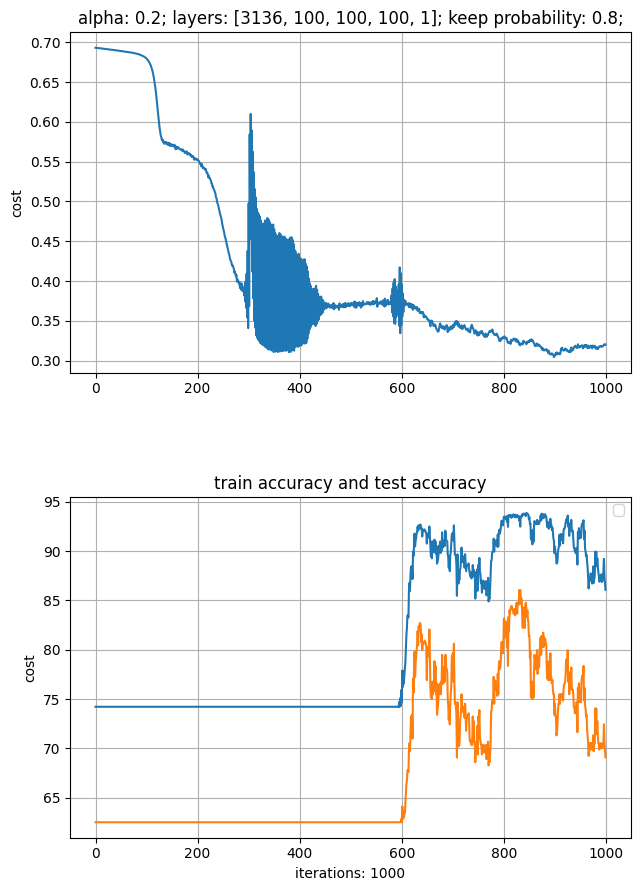

In [19]:
layer_dims = [train_X.shape[0], 100, 100, 100, train_Y.shape[0]]
learning_rate = 0.2
lambd = 1.0
keep_probability = 0.8
number_of_iterations = 1000
print_cost = True
print_graph = True
regularization = False
dropout = True

# Build a model with a n_h-dimensional hidden layer
parameters, costs, train_accuracy_values, test_accuracy_values = nn_model(
    X=train_X, 
    Y=train_Y, 
    layer_dims=layer_dims, 
    learning_rate=learning_rate, 
    lambd=lambd,
    keep_probability = keep_probability,
    num_iterations = number_of_iterations, 
    print_cost=print_cost, 
    print_graph=print_graph, 
    regularization=regularization,
    dropout=dropout
)

fig = plt.figure()
ax1 = fig.add_subplot(211)
ax1.set_ylabel('cost')
#ax1.set_xlabel('iterations: {}'.format(str(number_of_iterations)))
title_string = "alpha: {}; layers: {};".format(str(learning_rate), str(layer_dims))
if regularization:
    title_string = title_string + " lambda: {};".format(str(lambd))
if dropout:
    title_string = title_string + " keep probability: {};".format(str(keep_probability))

ax1.set_title(title_string)
ax1.grid(True)
ax1.plot(costs)

if print_graph:
    ax2 = fig.add_subplot(212)
    ax2.set_ylabel('cost')
    ax2.set_xlabel('iterations: {}'.format(str(number_of_iterations)))
    ax2.set_title("train accuracy and test accuracy")
    ax2.legend()
    ax2.grid(True)
    ax2.plot(train_accuracy_values, label='train accuracy')
    ax2.plot(test_accuracy_values, label='test accuracy')

# Configure padding between the subplots
fig.tight_layout(pad=1.0)
# Adjust for the height of the overall figure
fig.set_figheight(10)
plt.show()

<Figure size 640x480 with 0 Axes>

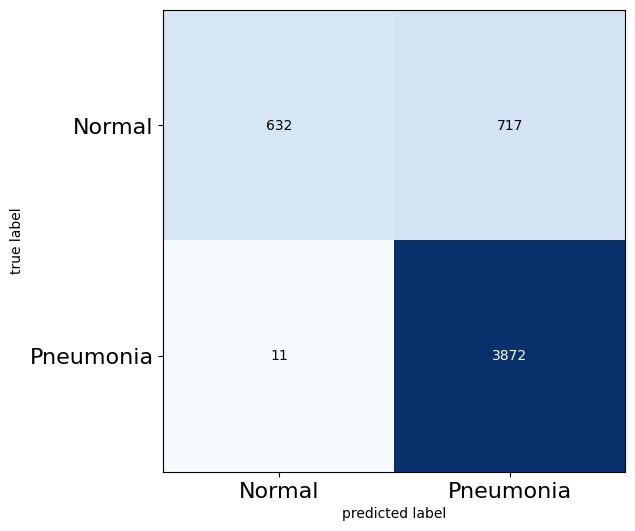

In [20]:
predictions = predict(parameters, train_X)
train_Y = train_Y.flatten()
predictions = predictions.flatten()
cm  = confusion_matrix(train_Y, predictions)
plt.figure()
plot_confusion_matrix(cm,figsize=(10,6), hide_ticks=True,cmap=plt.cm.Blues)
plt.xticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
plt.yticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
plt.show()

In [21]:
print('\nManually calculating...')
tn, fp, fn, tp = cm.ravel()

precision = tp/(tp+fp)
recall = tp/(tp+fn)

print("Recall of the model is {:.3f}".format(recall))
print("Precision of the model is {:.3f}".format(precision))


Manually calculating...
Recall of the model is 0.997
Precision of the model is 0.844
